# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
# magic word for producing visualizations in notebook
%matplotlib inline

'''
Import note: The classroom currently uses sklearn version 0.19.
If you need to use an imputer, it is available in sklearn.preprocessing.Imputer,
instead of sklearn.impute as in newer versions of sklearn.
'''

'\nImport note: The classroom currently uses sklearn version 0.19.\nIf you need to use an imputer, it is available in sklearn.preprocessing.Imputer,\ninstead of sklearn.impute as in newer versions of sklearn.\n'

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')
# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [3]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
print('The dimensions of the Azdias dataset are {}'.format(azdias.shape))
azdias.head()

The dimensions of the Azdias dataset are (891221, 85)


,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


In [4]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 891221 non-null int64
ALTERSKATEGORIE_GROB     891221 non-null int64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              891221 non-null int64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               891221 non-null int64
LP_LEBENSPHASE_FEIN      886367 non-null float64
LP_LEBENSPHASE_GROB      886367 non-null float64
LP_FAMILIE_FEIN          886367 non-null float64
LP_FAMILIE_GROB          886367 n

> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

In [5]:
feat_info

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]
5,FINANZ_SPARER,person,ordinal,[-1]
6,FINANZ_VORSORGER,person,ordinal,[-1]
7,FINANZ_ANLEGER,person,ordinal,[-1]
8,FINANZ_UNAUFFAELLIGER,person,ordinal,[-1]
9,FINANZ_HAUSBAUER,person,ordinal,[-1]


In [6]:
azdias.isna().sum().sum()

4896838

In [7]:
missing_list = []
for value in feat_info["missing_or_unknown"]:
    missing_list.append(value[1:-1].split(','))

# Identify missing or unknown data values and convert them to NaNs.
for attribute,missing_values_list in zip(feat_info["attribute"], missing_list):
    if missing_values_list[0] != "": # if the list not empty 
        for missing_value in missing_values_list:
            if missing_value.isnumeric() or missing_value.lstrip('-').isnumeric():#negative sign is considered 'not numeric'
                missing_value = int(missing_value)
            azdias.loc[azdias[attribute] == missing_value, attribute] = np.nan


In [8]:
azdias.isna().sum().sum()

8373929

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

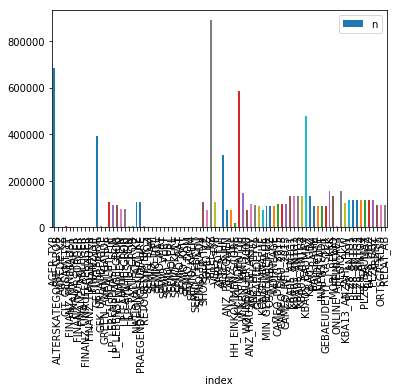

In [9]:
azdias.isna().sum().reset_index(name="n").plot.bar(x='index', y='n')

In [10]:
azdias.isna().sum().reset_index(name="n").sort_values(by="n", ascending=False)[0:10]

,index,n
40,TITEL_KZ,889061
0,AGER_TYP,685843
47,KK_KUNDENTYP,584612
64,KBA05_BAUMAX,476524
11,GEBURTSJAHR,392318
43,ALTER_HH,310267
70,KKK,158064
73,REGIOTYP,158064
48,W_KEIT_KIND_HH,147988
60,KBA05_ANTG1,133324


Looking at the histogram above shows there are some columns with many more missing values than others. I have tabulated the top 10 above. 'TITEL_KZ' is a clear outlier.

In [11]:
pct_null = azdias.isnull().sum() / len(azdias)
column_stats=pct_null.describe()
column_stats

count    85.000000
mean      0.110541
std       0.164498
min       0.000000
25%       0.000000
50%       0.104517
75%       0.130736
max       0.997576
dtype: float64

In [12]:
mean=column_stats[1]
std=column_stats[2]
outlier=mean + 3*std
print('Outlier columns have more than {} percent of the observations as missing values'.format(outlier*100))

Outlier columns have more than 60.403583591061086 percent of the observations as missing values


In [13]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)

print('Originally, there were {} columns'.format(azdias.shape[1]))
missing_features = pct_null[pct_null > outlier].index
azdias.drop(missing_features, axis=1, inplace=True)
print('After dropping outlier columns, there are {} columns'.format(azdias.shape[1]))

Originally, there were 85 columns
After dropping outlier columns, there are 82 columns


In [14]:
#change feat_info to reflect the removed columns
feat_info.set_index('attribute',inplace=True)
for i in list(missing_features):
    feat_info.drop(i, inplace=True)

#### Discussion 1.1.2: Assess Missing Data in Each Column

On average, the amount of missing values per row was 11%, but this was skewed by some outlier cases. The median was 10.45%. 
I decided to drop outlier columns. By definition, an outlier is 3 standard deviations from the mean. In this context, I dropped rows that had more than 60% missing values. 
Originally, the dataset had 85 columns. After dropping outlier columns, 82 columns remain.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

In [15]:
# How much data is missing in each row of the dataset?
missing_in_row = azdias.isnull().sum(axis=1)
pct_null_row = missing_in_row / azdias.shape[1]
row_stats=pct_null_row.describe()
row_stats

count    891221.000000
mean          0.085036
std           0.168026
min           0.000000
25%           0.012195
50%           0.024390
75%           0.048780
max           0.621951
dtype: float64

In [16]:
azdias.shape

(891221, 82)

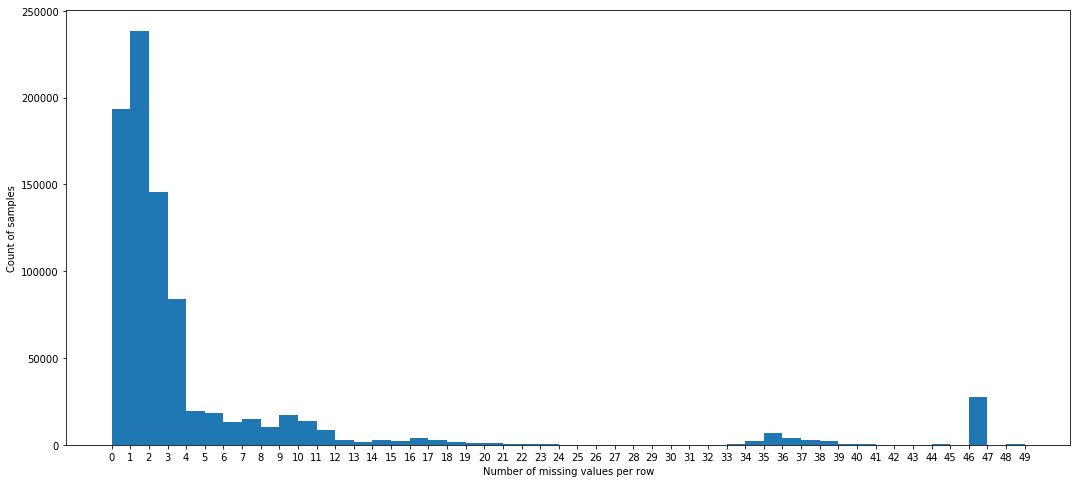

In [17]:
plt.figure(figsize=(18, 8))
plt.xticks(np.arange(0, 50, 1))
plt.xlabel('Number of missing values per row')
plt.ylabel('Count of samples')
plt.hist(missing_in_row, bins=np.arange(0, 50, 1))

plt.show();



In [18]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
missing_row_median = row_stats[5]
above_25per = pct_null_row[pct_null_row > .25].index
above_25per_df = azdias.loc[above_25per]
below_25per_df = azdias.drop(above_25per)


In [19]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
def compare_column_dist(df1, df2, column:str):
    print('Distribution of {} for observations below the median of missing rows'.format(column))
    print(df1[column].describe())
    print('Distribution of {} for obseravations above the median of missing rows'.format(column))
    print(df2[column].describe())
    return 
    


In [20]:
for i in ['ALTERSKATEGORIE_GROB', 'ANREDE_KZ', 'FINANZ_MINIMALIST', 'SEMIO_SOZ', 'LP_STATUS_FEIN']:
    print(compare_column_dist(df1=below_25per_df, df2=above_25per_df, column=i))

Distribution of ALTERSKATEGORIE_GROB for observations below the median of missing rows
count    793767.000000
mean          2.795296
std           1.018534
min           1.000000
25%           2.000000
50%           3.000000
75%           4.000000
max           4.000000
Name: ALTERSKATEGORIE_GROB, dtype: float64
Distribution of ALTERSKATEGORIE_GROB for obseravations above the median of missing rows
count    94573.000000
mean         2.437609
std          0.871527
min          1.000000
25%          2.000000
50%          3.000000
75%          3.000000
max          4.000000
Name: ALTERSKATEGORIE_GROB, dtype: float64
None
Distribution of ANREDE_KZ for observations below the median of missing rows
count    796538.000000
mean          1.521401
std           0.499542
min           1.000000
25%           1.000000
50%           2.000000
75%           2.000000
max           2.000000
Name: ANREDE_KZ, dtype: float64
Distribution of ANREDE_KZ for obseravations above the median of missing rows
count

In [21]:
azdias=below_25per_df

In [22]:
azdias.shape

(796538, 82)

#### Discussion 1.1.3: Assess Missing Data in Each Row

I decided to split the dataset by looking above and below 25% of columns in a row having missing values. The two subsets look similar along the five variables displayed above, besides slight differences in the 'SEMIO_SOZ' column. Therefore, I have dropped the rows with missing data in more than 25% of the columns to avoid cumbersome imputations.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [23]:
# How many features are there of each data type?
feat_info.type.value_counts()

ordinal        49
categorical    18
mixed           7
numeric         7
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In [24]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?
categorical_features=feat_info.query('type == "categorical"')
cat_list = list(categorical_features.index.values)

re_encode_cat=[]
for i in cat_list:
    print(i)
    # counting unique values
    unique_values = len(pd.unique(azdias[i]))
    print(azdias[i].value_counts())
    if azdias[i].isnull().sum() !=0:
            unique_values = unique_values-1
    print("Number of unique values for {}:".format(i), unique_values)
    if unique_values>2:
        azdias.drop(i, axis=1, inplace=True)
        print(i, " column has been dropped from the df due to multi-level categoricals")
    if unique_values<=2:
        re_encode_cat.append(i)
    print('-'*40)
print("The remaining variables to be re-encoded are ", re_encode_cat)

ANREDE_KZ
2.0    415316
1.0    381222
Name: ANREDE_KZ, dtype: int64
Number of unique values for ANREDE_KZ: 2
----------------------------------------
CJT_GESAMTTYP
4.0    197945
3.0    146958
2.0    141108
5.0    110980
6.0    101815
1.0     93117
Name: CJT_GESAMTTYP, dtype: int64
Number of unique values for CJT_GESAMTTYP: 6
CJT_GESAMTTYP  column has been dropped from the df due to multi-level categoricals
----------------------------------------
FINANZTYP
6.0    288947
1.0    196654
5.0    106159
2.0    104516
4.0     55853
3.0     44409
Name: FINANZTYP, dtype: int64
Number of unique values for FINANZTYP: 6
FINANZTYP  column has been dropped from the df due to multi-level categoricals
----------------------------------------
GFK_URLAUBERTYP
12.0    129840
10.0    102702
8.0      82962
11.0     74979
5.0      70446
4.0      60406
9.0      57014
3.0      53090
1.0      50630
2.0      43508
7.0      40630
6.0      25716
Name: GFK_URLAUBERTYP, dtype: int64
Number of unique values for GFK_

In [25]:
# Re-encode categorical variable(s) to be kept in the analysis.
for i in re_encode_cat:
    print(azdias[i].value_counts())
    print('-'*40)


2.0    415316
1.0    381222
Name: ANREDE_KZ, dtype: int64
----------------------------------------
0    621518
1    175020
Name: GREEN_AVANTGARDE, dtype: int64
----------------------------------------
0.0    789835
1.0      6703
Name: SOHO_KZ, dtype: int64
----------------------------------------
2.0    394009
1.0    366246
Name: VERS_TYP, dtype: int64
----------------------------------------
W    628242
O    168296
Name: OST_WEST_KZ, dtype: int64
----------------------------------------


In [26]:
#replace 'OST_WEST_KZ' values 'W' with 0 and 'O' with 1 (ie string to numeric)
azdias['OST_WEST_KZ'].replace(['W', 'O'],
                        [0, 1], inplace=True)

#### Discussion 1.2.1: Re-Encode Categorical Features

I decided to keep the project simple and drop all multi-level categoricals. 
This action left me with the following list: ['ANREDE_KZ', 'GREEN_AVANTGARDE', 'SOHO_KZ', 'VERS_TYP', 'OST_WEST_KZ'].
Of these columns, the only variable that required re-encoding was OST_WEST_KZ. For this column, I replaced values 'W' with 0 and 'O' with 1 (ie string to numeric)

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

#Data dictionary for PRAEGENDE_JUGENDJAHRE
- -1: unknown
-  0: unknown
-  1: 40s - war years (Mainstream, E+W)
-  2: 40s - reconstruction years (Avantgarde, E+W)
-  3: 50s - economic miracle (Mainstream, E+W)
-  4: 50s - milk bar / Individualisation (Avantgarde, E+W)
-  5: 60s - economic miracle (Mainstream, E+W)
-  6: 60s - generation 68 / student protestors (Avantgarde, W)
-  7: 60s - opponents to the building of the Wall (Avantgarde, E)
-  8: 70s - family orientation (Mainstream, E+W)
-  9: 70s - peace movement (Avantgarde, E+W)
- 10: 80s - Generation Golf (Mainstream, W)
- 11: 80s - ecological awareness (Avantgarde, W)
- 12: 80s - FDJ / communist party youth organisation (Mainstream, E)
- 13: 80s - Swords into ploughshares (Avantgarde, E)
- 14: 90s - digital media kids (Mainstream, E+W)
- 15: 90s - ecological awareness (Avantgarde, E+W)

In [27]:
def label_generation (row):
    if (
        (row['PRAEGENDE_JUGENDJAHRE'] == 1) | 
        (row['PRAEGENDE_JUGENDJAHRE'] == 2)
        ):
        return '1940'
    if (
        (row['PRAEGENDE_JUGENDJAHRE'] == 3) | 
        (row['PRAEGENDE_JUGENDJAHRE'] == 4)
        ):
        return '1950'
    if (
        (row['PRAEGENDE_JUGENDJAHRE'] == 5) | 
        (row['PRAEGENDE_JUGENDJAHRE'] == 6) | 
        (row['PRAEGENDE_JUGENDJAHRE'] == 7)
        ):
        return '1960'
    if (
        (row['PRAEGENDE_JUGENDJAHRE'] == 8) | 
        (row['PRAEGENDE_JUGENDJAHRE'] == 9)
        ): 
        return '1970'
    if (
        (row['PRAEGENDE_JUGENDJAHRE'] == 10) | 
        (row['PRAEGENDE_JUGENDJAHRE'] == 11) | 
        (row['PRAEGENDE_JUGENDJAHRE'] == 12) | 
        (row['PRAEGENDE_JUGENDJAHRE'] == 13)
        ): 
        return '1980'
    if (
        (row['PRAEGENDE_JUGENDJAHRE'] == 14) | 
        (row['PRAEGENDE_JUGENDJAHRE'] == 15) 
        ):
        return '1990'

In [28]:
azdias['GENERATION'] = azdias.apply(lambda row: label_generation(row), axis=1)

In [29]:
azdias_copy=azdias.copy()

In [30]:
#below is a function to create dummies and remove the original multi-level cat var
def create_dummies(var_name, df):
    #create dummies for multi-level categorical
    dummies = pd.get_dummies(df['{}'.format(var_name)]).rename(columns=lambda x: '{}'.format(var_name) + str(x))
    df = pd.concat([df, dummies], axis=1)
    #drop multi-level categorical
    df.drop('{}'.format(var_name), inplace=True, axis=1)
    return df

In [31]:
azdias=create_dummies('GENERATION', azdias)


In [32]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.
sorted(azdias.PRAEGENDE_JUGENDJAHRE.value_counts().index)
#40s: 1, 2
#50s: 3, 4
#60s: 5, 6, 7
#70s: 8, 9
#80s: 10, 11, 12, 13
#90s: 14, 15

[1.0,
 2.0,
 3.0,
 4.0,
 5.0,
 6.0,
 7.0,
 8.0,
 9.0,
 10.0,
 11.0,
 12.0,
 13.0,
 14.0,
 15.0]

In [33]:
#movement

#mainstream: 1, 3, 5, 8, 10, 12, 14
#avantgarde: 2, 4, 6, 7, 9, 11, 13, 15

In [34]:
def label_movement (row):
    if (
        (row['PRAEGENDE_JUGENDJAHRE'] == 1) | 
        (row['PRAEGENDE_JUGENDJAHRE'] == 3) | 
        (row['PRAEGENDE_JUGENDJAHRE'] == 5) | 
        (row['PRAEGENDE_JUGENDJAHRE'] == 8) |
        (row['PRAEGENDE_JUGENDJAHRE'] == 10) | 
        (row['PRAEGENDE_JUGENDJAHRE'] == 12) | 
        (row['PRAEGENDE_JUGENDJAHRE'] == 14)          
        ): 
        return '0'
    else:
        return '1'

In [35]:
# Investigate "CAMEO_INTL_2015" and engineer two new variables.

azdias['MOVEMENT'] = azdias.apply(lambda row: label_movement(row), axis=1)

In [36]:
azdias.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True) #drop the now defunct variable

In [37]:
azdias['CAMEO_INTL_2015'] = azdias['CAMEO_INTL_2015'].astype(str)

azdias['WEALTH'] = azdias['CAMEO_INTL_2015'].astype(str).str[0]
azdias['WEALTH']= pd.to_numeric(azdias['WEALTH'], errors='coerce')

azdias['LIFE_STAGE'] = azdias['CAMEO_INTL_2015'].astype(str).str[1]
azdias['LIFE_STAGE']= pd.to_numeric(azdias['LIFE_STAGE'], errors='coerce')

In [38]:
azdias[['CAMEO_INTL_2015', 'WEALTH', 'LIFE_STAGE']][0:10]

,CAMEO_INTL_2015,WEALTH,LIFE_STAGE
1,51,5.0,1.0
2,24,2.0,4.0
3,12,1.0,2.0
4,43,4.0,3.0
5,54,5.0,4.0
6,22,2.0,2.0
7,14,1.0,4.0
8,13,1.0,3.0
9,15,1.0,5.0
10,51,5.0,1.0


In [39]:
azdias=create_dummies('WEALTH', azdias)
azdias=create_dummies('LIFE_STAGE', azdias)

In [40]:
azdias.drop('CAMEO_INTL_2015', axis=1, inplace=True) #drop the now defunct variable

#### Discussion 1.2.2: Engineer Mixed-Type Features

I made column 'PRAEGENDE_JUGENDJAHRE' into two columns: generation and movement. Generation is a multi-level categorical, so I converted it to dummies. I then dropped the original 'PRAEGENDE_JUGENDJAHRE' and 'GENERATION' columns. 
I also made 'CAMEO_INTL_2015' into two columns: wealth and life stage. Both wealth and lifestage are multi-level categoricals, so I converted them both to dummies. I then dropped the original 'CAMEO_INTL_2015', 'WEALTH', and 'LIFE_STAGE' columns.

#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

In [41]:
azdias.drop('GEBURTSJAHR', axis=1, inplace=True) #drop the variable with many missing values
azdias.drop('ALTER_HH', axis=1, inplace=True) #drop the variable with many missing values
azdias.drop('KBA05_BAUMAX', axis=1, inplace=True) #drop the variable with many missing values

### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [42]:
def clean_data(azdias):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: Demographics DataFrame
    OUTPUT: Trimmed and cleaned demographics DataFrame
    """
    missing_list = []
    for value in feat_info["missing_or_unknown"]:
        missing_list.append(value[1:-1].split(','))

    # Identify missing or unknown data values and convert them to NaNs.
    for attribute,missing_values_list in zip(feat_info["attribute"], missing_list):
        if missing_values_list[0] != "": # if the list not empty 
            for missing_value in missing_values_list:
                #check if the missing value is number (negative or positive numbers)
                if missing_value.isnumeric() or missing_value.lstrip('-').isnumeric():
                    missing_value = int(missing_value)
                azdias.loc[azdias[attribute] == missing_value, attribute] = np.nan

    #Identify outlier columns with respect to missing values
    pct_null = azdias.isnull().sum() / len(azdias)
    column_stats=pct_null.describe()
    mean=column_stats[1]
    std=column_stats[2]
    outlier=mean + 3*std

    #drop outlier columns
    print('Originally, there were {} columns'.format(azdias.shape[1]))
    missing_features = pct_null[pct_null > outlier].index
    azdias.drop(missing_features, axis=1, inplace=True)
    print('After dropping outlier columns, there are {} columns'.format(azdias.shape[1]))

    #drop columns from feature info dataset
    feat_info.set_index('attribute',inplace=True)
    for i in list(missing_features):
        feat_info.drop(i, inplace=True)

    #Identify missing values in rows
    pct_null_row = azdias.isnull().sum(axis=1) / azdias.shape[1]
    above_per25 = pct_null_row[pct_null_row > 0.25].index
    above_per25_df = azdias.loc[above_per25]
    below_per25_df = azdias.drop(above_per25)

    #drop missing value rows above median
    azdias=below_per25_df

    #drop multi-level categorical values
    categorical_features=feat_info.query('type == "categorical"')
    cat_list = list(categorical_features.index.values)
    re_encode_cat=[]
    for i in cat_list:
    #    print(i)
        # counting unique values
        unique_values = len(pd.unique(azdias[i]))
    #    print(azdias[i].value_counts())
        if azdias[i].isnull().sum() !=0:
                unique_values = unique_values-1
    #    print("Number of unique values for {}:".format(i), unique_values)
        if unique_values>2:
            azdias.drop(i, axis=1, inplace=True)
    #        print(i, " column has been dropped from the df due to multi-level categoricals")
        if unique_values<=2:
            re_encode_cat.append(i)
    #    print('-'*40)
    #print("The remaining variables to be re-encoded are ", re_encode_cat)

    #replace 'OST_WEST_KZ' values 'W' with 0 and 'O' with 1 (ie string to numeric)
    azdias['OST_WEST_KZ'].replace(['W', 'O'],
                            [0, 1], inplace=True)

    # Create generation and movement features from 'PRAEGENDE_JUGENDJAHRE'
    azdias['GENERATION'] = azdias.apply(lambda row: label_generation(row), axis=1)

    azdias['MOVEMENT'] = azdias.apply(lambda row: label_movement(row), axis=1)

    azdias.drop('PRAEGENDE_JUGENDJAHRE', axis=1, inplace=True) #drop the now defunct variable

    #Create wealth and lifespan features from CAMEO_INTL_2015
    azdias['CAMEO_INTL_2015'] = azdias['CAMEO_INTL_2015'].astype(str)

    azdias['WEALTH'] = azdias['CAMEO_INTL_2015'].astype(str).str[0]
    azdias['WEALTH']= pd.to_numeric(azdias['WEALTH'], errors='coerce')

    azdias['LIFE_STAGE'] = azdias['CAMEO_INTL_2015'].astype(str).str[1]
    azdias['LIFE_STAGE']= pd.to_numeric(azdias['LIFE_STAGE'], errors='coerce')

    azdias.drop('CAMEO_INTL_2015', axis=1, inplace=True) #drop the now defunct variable

    azdias.drop('GEBURTSJAHR', axis=1, inplace=True) #drop the variable with many missing values
    azdias.drop('ALTER_HH', axis=1, inplace=True) #drop the variable with many missing values
    azdias.drop('KBA05_BAUMAX', axis=1, inplace=True) #drop the variable with many missing values
    azdias=create_dummies('GENERATION', azdias)
    azdias=create_dummies('WEALTH', azdias)
    azdias=create_dummies('LIFE_STAGE', azdias)

    azdias_clean = azdias
    return azdias_clean 

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](https://scikit-learn.org/0.16/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In [43]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 796538 entries, 1 to 891220
Data columns (total 81 columns):
ALTERSKATEGORIE_GROB     793767 non-null float64
ANREDE_KZ                796538 non-null float64
FINANZ_MINIMALIST        796538 non-null float64
FINANZ_SPARER            796538 non-null float64
FINANZ_VORSORGER         796538 non-null float64
FINANZ_ANLEGER           796538 non-null float64
FINANZ_UNAUFFAELLIGER    796538 non-null float64
FINANZ_HAUSBAUER         796538 non-null float64
GREEN_AVANTGARDE         796538 non-null int64
HEALTH_TYP               760255 non-null float64
LP_LEBENSPHASE_FEIN      747147 non-null float64
LP_LEBENSPHASE_GROB      749952 non-null float64
RETOURTYP_BK_S           791923 non-null float64
SEMIO_SOZ                796538 non-null float64
SEMIO_FAM                796538 non-null float64
SEMIO_REL                796538 non-null float64
SEMIO_MAT                796538 non-null float64
SEMIO_VERT               796538 non-null float64
SEMIO_LUS

In [44]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
azdias.dropna(inplace=True)


In [45]:
azdias.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 632124 entries, 1 to 891220
Data columns (total 81 columns):
ALTERSKATEGORIE_GROB     632124 non-null float64
ANREDE_KZ                632124 non-null float64
FINANZ_MINIMALIST        632124 non-null float64
FINANZ_SPARER            632124 non-null float64
FINANZ_VORSORGER         632124 non-null float64
FINANZ_ANLEGER           632124 non-null float64
FINANZ_UNAUFFAELLIGER    632124 non-null float64
FINANZ_HAUSBAUER         632124 non-null float64
GREEN_AVANTGARDE         632124 non-null int64
HEALTH_TYP               632124 non-null float64
LP_LEBENSPHASE_FEIN      632124 non-null float64
LP_LEBENSPHASE_GROB      632124 non-null float64
RETOURTYP_BK_S           632124 non-null float64
SEMIO_SOZ                632124 non-null float64
SEMIO_FAM                632124 non-null float64
SEMIO_REL                632124 non-null float64
SEMIO_MAT                632124 non-null float64
SEMIO_VERT               632124 non-null float64
SEMIO_LUS

In [46]:
# Apply feature scaling to the general population demographics data.
scaler = StandardScaler()
azdias_ss=scaler.fit_transform(azdias)


### Discussion 2.1: Apply Feature Scaling

In preparation for feature scaling, I decided to drop all rows with any missing values.

For feature scaling, I used the standard scalar, which scaled each feature to mean 0 and standard deviation 1.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [47]:
#from udacity course
def pca_fn(num_comp, df):
    pca = PCA(num_comp)
    X_pca = pca.for_transform(azdias_ss)
    return pca, X_pca

In [48]:
# Apply PCA to the data.
pca = PCA()
X_pca = pca.fit_transform(azdias_ss)
# Investigate the variance accounted for by each principal component.
print(pca.explained_variance_ratio_)

[  1.53726481e-01   1.14009623e-01   7.66580586e-02   4.83483023e-02
   3.50352203e-02   2.75856256e-02   2.63265358e-02   2.41005134e-02
   2.27346553e-02   2.12311410e-02   2.00525471e-02   1.78146980e-02
   1.69369766e-02   1.61483967e-02   1.53033528e-02   1.50946268e-02
   1.49012878e-02   1.42457041e-02   1.37993133e-02   1.35386889e-02
   1.31549891e-02   1.28236592e-02   1.24451139e-02   1.23411367e-02
   1.18308294e-02   1.17095590e-02   1.09368918e-02   1.06861652e-02
   1.02630330e-02   9.48548837e-03   9.44773995e-03   9.20575647e-03
   8.66066444e-03   8.43908268e-03   8.11910515e-03   7.62826264e-03
   6.35768256e-03   6.21367529e-03   6.02228557e-03   5.83433940e-03
   5.68668685e-03   5.55578562e-03   5.26246196e-03   5.12357301e-03
   4.87052783e-03   4.70591680e-03   4.54987722e-03   3.83580761e-03
   3.63216274e-03   3.45395027e-03   3.37070509e-03   3.28106377e-03
   3.09399747e-03   3.02356906e-03   2.90969777e-03   2.81835076e-03
   2.74318563e-03   2.56223059e-03

In [49]:
#from udacity course
def do_pca(n_components, data):
    X = StandardScaler().fit_transform(data)
    pca = PCA(n_components)
    X_pca = pca.fit_transform(X)
    return pca, X_pca

In [50]:
#from udacity course with modifications
def pca_results(full_dataset, pca, dim=None, graph=False):

    # Dimension indexing
    dimensions = ['Dimension {}'.format(i) for i in range(1,len(pca.components_)+1)]

    # PCA components
    components = pd.DataFrame(np.round(pca.components_, 4), columns = full_dataset.keys())
    components.index = dimensions


    # PCA explained variance
    ratios = pca.explained_variance_ratio_.reshape(len(pca.components_), 1)
    variance_ratios = pd.DataFrame(np.round(ratios, 4), columns = ['Explained Variance'])
    variance_ratios.index = dimensions


    # Return a concatenated DataFrame
    if dim == None:
        
        return pd.concat([variance_ratios, components], axis = 1)
    
    
    df = pd.concat([variance_ratios, components], axis = 1)
    df_transpose=df[dim-1:dim].sort_index(axis=0)
    df_transpose = df_transpose.T
    df_transpose = df_transpose.sort_values(by='Dimension {}'.format(dim))
    df_exp_var = df_transpose.loc[['Explained Variance']]
    df_transpose = df_transpose.drop(index='Explained Variance')
    df_transpose_bottom10 = df_transpose[0:9]
    df_transpose_top10 = df_transpose[-9:]
    df_top_bottom_10= pd.concat([df_transpose_bottom10, df_transpose_top10])
    df_new = pd.concat([df_exp_var, df_transpose_bottom10, df_transpose_top10])
    if graph == True:
        
        df_top_bottom_10.sort_values(by='Dimension {}'.format(dim)).plot(kind='bar', 
                      title='The Top 10 Positive and Negative weighted features for PCA component {}'.format(dim),
                      figsize=(12, 6))
        plt.show()
    

    return df_new


In [51]:
#from udacity course
for comp in range(15, 40):
    pca, X_pca = do_pca(comp, azdias_ss)
    comp_check = pca_results(azdias, pca)
    if comp_check['Explained Variance'].sum() > 0.85:
        break
        

num_comps = comp_check.shape[0]
print("Using {} components, we can explain {}% of the variability in the original data.".format(comp_check.shape[0],comp_check['Explained Variance'].sum()))

Using 33 components, we can explain 0.8501% of the variability in the original data.


### Discussion 2.2: Perform Dimensionality Reduction

I used the benchmark of 85% explained variance to decide to keep 33 components. Therefore, azdias is reduced from 81 columns down to 33. 

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

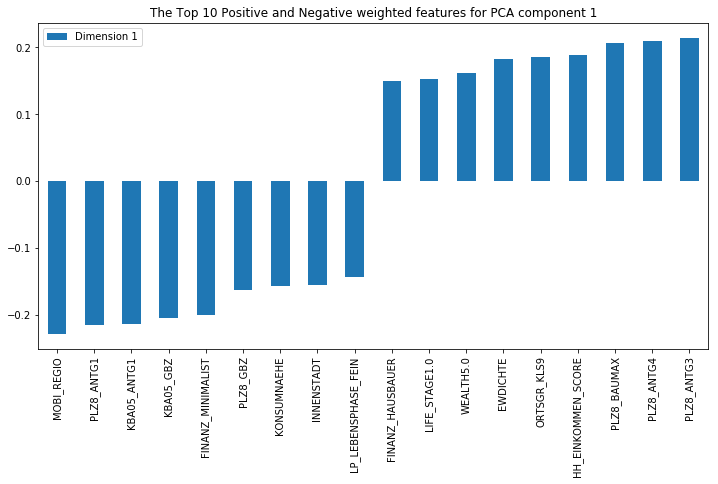

,Dimension 1
Explained Variance,0.1537
MOBI_REGIO,-0.2293
PLZ8_ANTG1,-0.2164
KBA05_ANTG1,-0.2141
KBA05_GBZ,-0.2046
FINANZ_MINIMALIST,-0.2000
PLZ8_GBZ,-0.1636
KONSUMNAEHE,-0.1573
INNENSTADT,-0.1552
LP_LEBENSPHASE_FEIN,-0.1435


In [52]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.
pca_results(azdias, pca, dim=1 , graph=True)

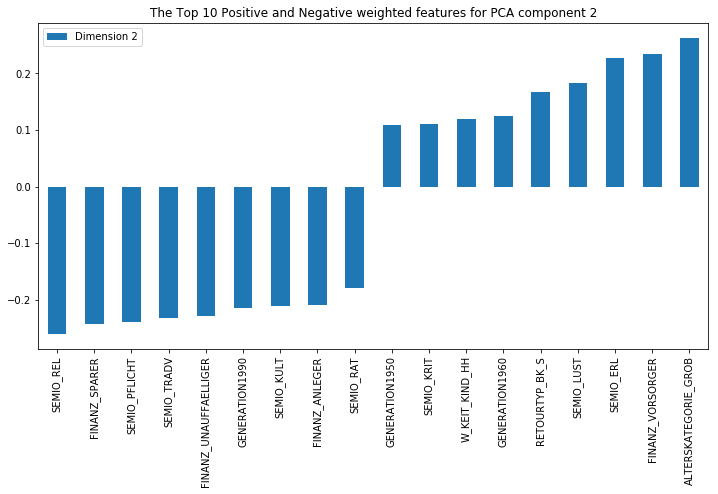

,Dimension 2
Explained Variance,0.1140
SEMIO_REL,-0.2611
FINANZ_SPARER,-0.2431
SEMIO_PFLICHT,-0.2404
SEMIO_TRADV,-0.2318
FINANZ_UNAUFFAELLIGER,-0.2294
GENERATION1990,-0.2153
SEMIO_KULT,-0.2122
FINANZ_ANLEGER,-0.2098
SEMIO_RAT,-0.1798


In [53]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.
pca_results(azdias, pca, dim=2 , graph=True)


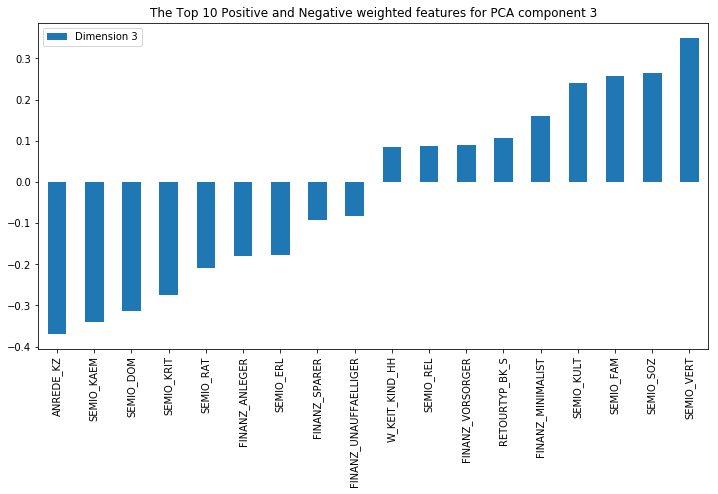

,Dimension 3
Explained Variance,0.0767
ANREDE_KZ,-0.3698
SEMIO_KAEM,-0.3411
SEMIO_DOM,-0.3134
SEMIO_KRIT,-0.2750
SEMIO_RAT,-0.2093
FINANZ_ANLEGER,-0.1802
SEMIO_ERL,-0.1785
FINANZ_SPARER,-0.0936
FINANZ_UNAUFFAELLIGER,-0.0830


In [54]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

pca_results(azdias, pca, dim=3, graph=True)

### Discussion 2.3: Interpret Principal Components

The first principal component is most strongly related to individuals with high movement patterns (MOBI_REGIO), who live in areas with less multi-family housing (PLZ8_ANTG3), and duplex housing (KBA05_ANTG1).

The second principal component is most strongly related to individuals who are older (ALTERSKATEGORIE_GROB), have a low level of affinity for religion (SEMIO_REL), and tend to be high money-savers (FINANZ_SPARER). 

The third principal component is most strongly related to males (ANREDE_KZ), with low affinity to dreamful personalities (SEMIO_VERT), and high affinity for having combative attitudes (SEMIO_KAEM).  

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

In [55]:
#subset the data to 25% of original
azdias_X_pca_25percent = X_pca[np.random.choice(X_pca.shape[0], int(X_pca.shape[0]*0.25), replace=False)]

In [56]:
sse = [] # Sum of Squared Errors
k_range = np.arange(10, 30)

for k in k_range:
    kmeans = KMeans(k, random_state=1234, max_iter=30, n_jobs=-1).fit(azdias_X_pca_25percent)
    score = np.abs(kmeans.score(azdias_X_pca_25percent))
    sse.append(score)
    print('Clustering done for {} k, with SSE {}'.format(k, score))

Clustering done for 10 k, with SSE 6988486.693192286
Clustering done for 11 k, with SSE 6897829.183934376
Clustering done for 12 k, with SSE 6809775.626237479
Clustering done for 13 k, with SSE 6688720.565431373
Clustering done for 14 k, with SSE 6620097.670572687
Clustering done for 15 k, with SSE 6539023.663943738
Clustering done for 16 k, with SSE 6415425.10243467
Clustering done for 17 k, with SSE 6332627.462658299
Clustering done for 18 k, with SSE 6282423.056994617
Clustering done for 19 k, with SSE 6228960.173205276
Clustering done for 20 k, with SSE 6189862.039641419
Clustering done for 21 k, with SSE 6112035.041409206
Clustering done for 22 k, with SSE 6064009.657016496
Clustering done for 23 k, with SSE 6016846.879309648
Clustering done for 24 k, with SSE 5987283.531538313
Clustering done for 25 k, with SSE 5940540.2491435325
Clustering done for 26 k, with SSE 5894555.555571647
Clustering done for 27 k, with SSE 5850057.651103669
Clustering done for 28 k, with SSE 5802535.286

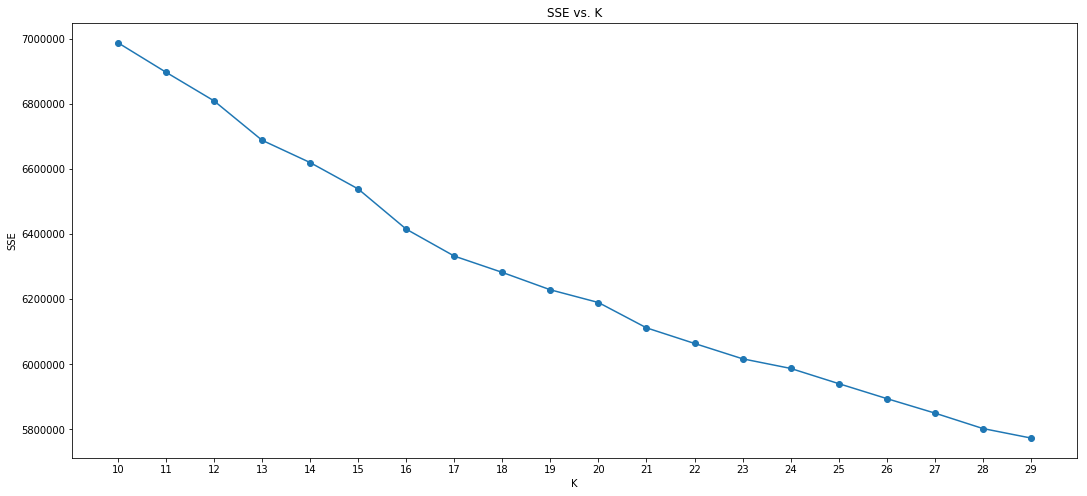

In [57]:
# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

#Elbow Method to identify optimal cluster k
plt.figure(figsize=(18, 8))
plt.xticks(np.arange(0, k_range[-1]+1, step=1))
plt.xlabel('K')
plt.ylabel('SSE')
plt.title('SSE vs. K')
plt.plot(k_range, sse, linestyle='-', marker='o');

In [58]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
k = 21
kmeans = KMeans(k, random_state=1234, max_iter=30, n_jobs=-1).fit(X_pca)
population_clusters = kmeans.predict(X_pca)


### Discussion 3.1: Apply Clustering to General Population

I used a 25% random sample to test different cluster numbers. I depicted them and used the elbow method to decide upon an optimal cluster number. There last substantial drop in SSE occured at k=21. I then fit the full sample using k=21 clusters. 

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [59]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
customers.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 191652 entries, 0 to 191651
Data columns (total 85 columns):
AGER_TYP                 191652 non-null int64
ALTERSKATEGORIE_GROB     191652 non-null int64
ANREDE_KZ                191652 non-null int64
CJT_GESAMTTYP            188439 non-null float64
FINANZ_MINIMALIST        191652 non-null int64
FINANZ_SPARER            191652 non-null int64
FINANZ_VORSORGER         191652 non-null int64
FINANZ_ANLEGER           191652 non-null int64
FINANZ_UNAUFFAELLIGER    191652 non-null int64
FINANZ_HAUSBAUER         191652 non-null int64
FINANZTYP                191652 non-null int64
GEBURTSJAHR              191652 non-null int64
GFK_URLAUBERTYP          188439 non-null float64
GREEN_AVANTGARDE         191652 non-null int64
HEALTH_TYP               191652 non-null int64
LP_LEBENSPHASE_FEIN      188439 non-null float64
LP_LEBENSPHASE_GROB      188439 non-null float64
LP_FAMILIE_FEIN          188439 non-null float64
LP_FAMILIE_GROB          188439 n

In [60]:
# Apply preprocessing, feature transformation, and clustering from the general
# demographics onto the customer data, obtaining cluster predictions for the
# customer demographics data.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')
clean_customer=clean_data(customers)


Originally, there were 85 columns
After dropping outlier columns, there are 84 columns


In [61]:
clean_customer.dropna(inplace=True)

clean_customer_std = scaler.transform(clean_customer)
clean_customer_pca = pca.transform(clean_customer_std)
customer_clusters = kmeans.predict(clean_customer_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

In [62]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
population_clusters = pd.Series(population_clusters)
population_clusters = population_clusters.value_counts().sort_index()

customer_clusters = pd.Series(customer_clusters)
customer_clusters = customer_clusters.value_counts().sort_index()

In [63]:
# Create a dataset summarizing clustering information
pop_and_cust = pd.concat([population_clusters, customer_clusters], axis=1).reset_index()
pop_and_cust.columns = ['cluster', 'population', 'customers']

# Sort by cluster (index)
pop_and_cust.sort_index(inplace=True)

# Calculate proprotions
pop_and_cust['cust_prop'] = pop_and_cust['customers'] / pop_and_cust['customers'].sum()
pop_and_cust['pop_prop'] = pop_and_cust['population'] / pop_and_cust['population'].sum()

# Calculate difference between cust and pop proportions
pop_and_cust['diff'] = pop_and_cust['cust_prop'] - pop_and_cust['pop_prop']


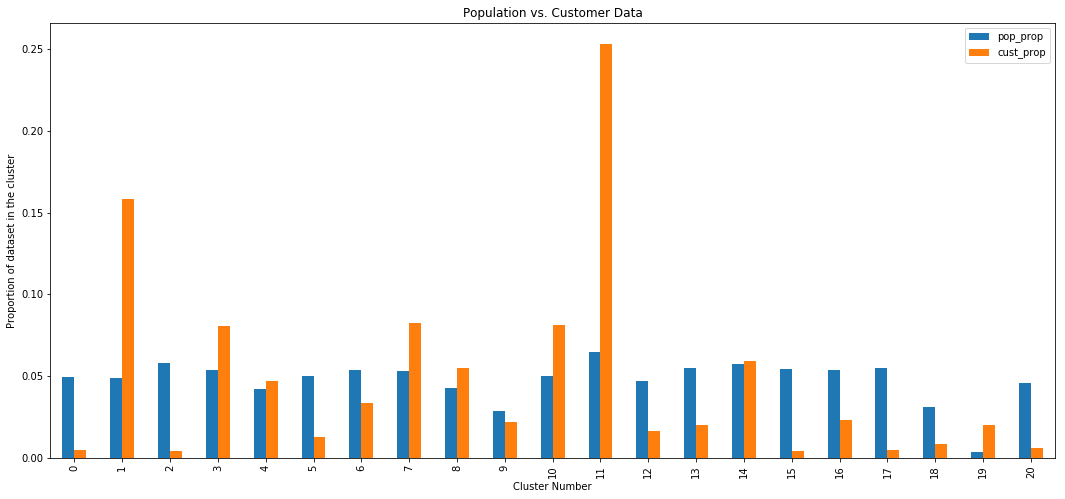

In [64]:
pop_and_cust.plot(x='cluster', y=['pop_prop', 'cust_prop'], kind='bar', figsize=(18, 8))
plt.title('Population vs. Customer Data')
plt.xlabel('Cluster Number')
plt.ylabel('Proportion of dataset in the cluster')
plt.show()

In [83]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
cluster11 = kmeans.cluster_centers_[11]
cluster11 = pd.Series(cluster11)
cluster11.index += 1 
cluster11.sort_values(ascending=False, inplace=True)
print(cluster11.head(5))

3     2.880637
4     2.504551
2     0.215710
11    0.183401
27    0.142834
dtype: float64


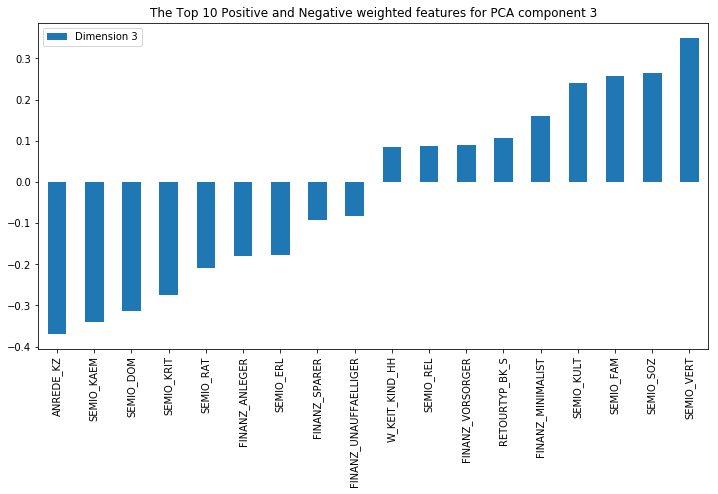

,Dimension 3
Explained Variance,0.0767
ANREDE_KZ,-0.3698
SEMIO_KAEM,-0.3411
SEMIO_DOM,-0.3134
SEMIO_KRIT,-0.2750
SEMIO_RAT,-0.2093
FINANZ_ANLEGER,-0.1802
SEMIO_ERL,-0.1785
FINANZ_SPARER,-0.0936
FINANZ_UNAUFFAELLIGER,-0.0830


In [84]:
pca_results(clean_customer, pca, dim=3, graph=True)

The eleventh cluster is over represented by the customer data relative to the population data. The third principal component captures the most variation in the cluster. The third principal component is most strongly related to males (ANREDE_KZ), with low affinity to dreamful personalities (SEMIO_VERT), and high affinity for having combative attitudes (SEMIO_KAEM).

In [85]:
# What additional kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
cluster1 = kmeans.cluster_centers_[1]
cluster1 = pd.Series(cluster1)
cluster1.index += 1 
cluster1.sort_values(ascending=False, inplace=True)
print(cluster1.head(5))

3     2.537791
2     1.000340
11    0.350723
7     0.335495
12    0.305716
dtype: float64


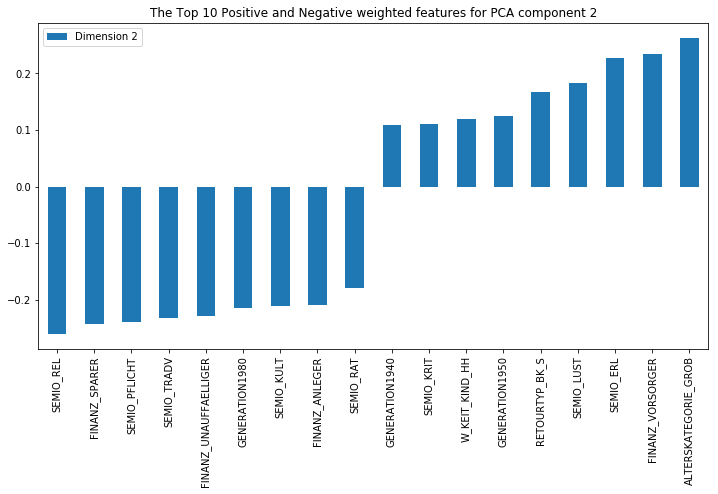

,Dimension 2
Explained Variance,0.1140
SEMIO_REL,-0.2611
FINANZ_SPARER,-0.2431
SEMIO_PFLICHT,-0.2404
SEMIO_TRADV,-0.2318
FINANZ_UNAUFFAELLIGER,-0.2294
GENERATION1980,-0.2153
SEMIO_KULT,-0.2122
FINANZ_ANLEGER,-0.2098
SEMIO_RAT,-0.1798


In [86]:
pca_results(clean_customer, pca, dim=2, graph=True)

Another cluster over represented in the customer data is cluster 1. This cluster is also related to the third principal component as well as the second principal component. The second principal component is most strongly related to individuals who are older (ALTERSKATEGORIE_GROB), have a low level of affinity for religion (SEMIO_REL), and tend to be high money-savers (FINANZ_SPARER). 

In [87]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
cluster15 = kmeans.cluster_centers_[15]
cluster15 = pd.Series(cluster15)
cluster15.index += 1 
cluster15.sort_values(ascending=False, inplace=True)
print(cluster15.head(5)) 

1     2.226523
3     2.002001
15    0.435390
18    0.304750
6     0.228181
dtype: float64


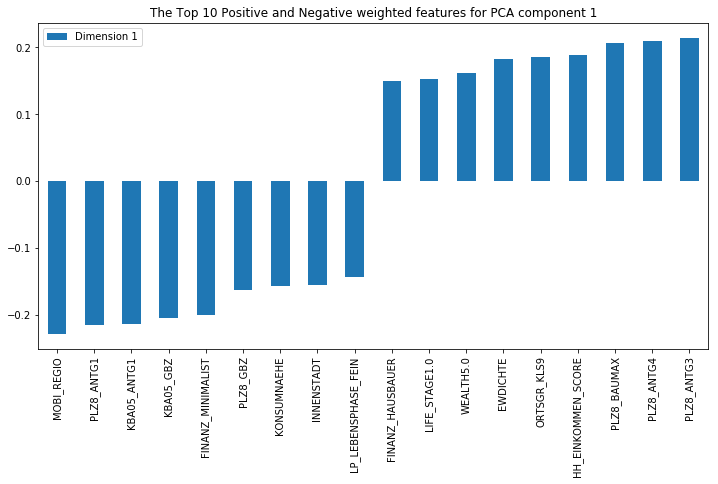

,Dimension 1
Explained Variance,0.1537
MOBI_REGIO,-0.2293
PLZ8_ANTG1,-0.2164
KBA05_ANTG1,-0.2141
KBA05_GBZ,-0.2046
FINANZ_MINIMALIST,-0.2000
PLZ8_GBZ,-0.1636
KONSUMNAEHE,-0.1573
INNENSTADT,-0.1552
LP_LEBENSPHASE_FEIN,-0.1435


In [88]:
pca_results(clean_customer, pca, dim=1, graph=True)

Cluster 15 is  under-represented by the customer data relative to the population data. The fourteenth principal component captures the most variation in the cluster. This principal component is most strongly related to elders in retirement (LIFE_STAGE5) who are prosperous (WEALTH2).

### Discussion 3.3: Compare Customer Data to Demographics Data

This analysis suggests that the typical customers for the company are males who are pragmatic and opinionated. They also older and good money savers.
An under-represented group in the customer data are elders in retirement who are prosperous. 
If the company was to tailor advertising to a target group, focusing on older males would be the best spend of their marketing budget given that just over 40% of their customer base belongs to the two clusters related to these characteristics. 